#### Описание эвристики (см. функции `apply_dummy_heuristics`):
Для каждого построенного слоя (двигаемся сверху вниз, кроме самого первого слоя) перебираем все пары вершин и пытаемся их переставить местами. Ищем пару, которая максимально уменьшит число пересечений рёбер (относительно лишь слоя выше). То есть алгоритм жадный. Для ускорения применил некоторые оптимизации (например, считаем только то, что могло поменяться, то есть внутри промежука (u,v), если пытаемся поменять u и v внутри фиксированного слоя).

#### Используемые примеры.
Для алгоритмов Грэхема-Коффмана, для алгоритма минимизации dummy-вершин с/без эвристики уменьшения числа пересечений рёбер приведены по 2 примера. Примеры для всех 3х алгоритмов одинаковые: 
* `example.graphml` - мой собственный
* `example2.graphml` - с лекции.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
from scipy.optimize import linprog
import numpy as np
import math

def tweaky_top_sort(G, adj_mtx):
    N = len(adj_mtx)
    masses = {
        node: 10000 # like +INF
        for node in G.nodes
    }

    result = []
    done_items = 0
    while done_items < N:
        predess_masses = {
            node: []
            for node in G.nodes if node not in result
        }
        for node, succs in adj_mtx.items():
            for succ in succs:
                if succ in result:
                    continue
                predess_masses[succ].append(masses[node])
        for node in predess_masses:
            predess_masses[node].sort(reverse=True)
        
        items_rev = [(item[1], item[0]) for item in predess_masses.items()]
        _, cur_node = min(items_rev)
        result.append(cur_node)
        
        masses[cur_node] = done_items
        
        done_items += 1
        continue 
    
    return result
    

def edge_inside_current_layer(succs, cur_layer_nodes):
    for cur_layer_node in cur_layer_nodes:
        if cur_layer_node in succs:
            return True
    return False


def add_dummy_nodes(adj_mtx, node_to_ind, y_coords, layers):
    nodes = adj_mtx.keys()
    fic_counter = 0
    dummy_nodes = set()
    adj_mtx_snapshot = dict(adj_mtx)
    for node, succs in adj_mtx_snapshot.items():
        for succ in succs:
            for extra_layer_ind in range(y_coords[node_to_ind[succ]], y_coords[node_to_ind[node]] - 1):
                fic_node_name = f'fic{fic_counter}_' + node + '-' + succ
                fic_counter += 1
                adj_mtx.update(
                    {
                        fic_node_name: [succ]
                    }
                )
                adj_mtx[node].remove(succ)
                adj_mtx[node].append(fic_node_name)
                layers[extra_layer_ind].append(fic_node_name)
                node_to_ind.update(
                    {
                        fic_node_name: len(node_to_ind)
                    }
                )
                y_coords.append(extra_layer_ind + 1)
                dummy_nodes.add(fic_node_name)
                
    return layers, dummy_nodes


def transposes_diff_if_shuffle_layer(
    adj_mtx, 
    node_to_ind,
    y_coords,
    layers,
    layer_ind,
    layer_node_to_ind,
    i, 
    j
):
    transposes_diff = 0
    for k in range(len(layers[layer_ind + 1]) - 1):
        prev_node_1 = layers[layer_ind + 1][k]
        for l in range(k + 1, len(layers[layer_ind + 1])):
            prev_node_2 = layers[layer_ind + 1][l]
            
            for prev_node_1_succ in adj_mtx[prev_node_1]:
                prev_node_1_succ_ind = layer_node_to_ind[prev_node_1_succ]
                if not (prev_node_1_succ_ind >= i and prev_node_1_succ_ind <= j):
                    continue
                for prev_node_2_succ in adj_mtx[prev_node_2]:
                    prev_node_2_succ_ind = layer_node_to_ind[prev_node_2_succ]
                    if not (prev_node_2_succ_ind >= i and prev_node_2_succ_ind <= j):
                        continue
                    if prev_node_2_succ_ind == prev_node_1_succ_ind:
                        continue

                    if prev_node_1_succ_ind in [i, j] or prev_node_2_succ_ind in [i, j]:
                        new_ind_1 = prev_node_2_succ_ind if prev_node_1_succ_ind == i else prev_node_1_succ_ind
                        if prev_node_1_succ_ind == j:
                            new_ind_1 = i
                        new_ind_2 = prev_node_1_succ_ind if prev_node_2_succ_ind == i else prev_node_2_succ_ind
                        if prev_node_2_succ_ind == j:
                            new_ind_2 = i

                        transposes_diff += -1 if new_ind_1 < new_ind_2 else 1

    return transposes_diff
    

def try_shuffle_layer(adj_mtx, node_to_ind, y_coords, layers, layer_ind):
    if len(layers[layer_ind]) < 2 or len(layers[layer_ind + 1]) < 2:
        return False
    
    layer_node_to_ind = {
        node: ind 
        for ind, node in enumerate(layers[layer_ind])
    }
    
    min_transposes_diff = 0
    mem_cur_layer_node_1_ind = None
    mem_cur_layer_node_2_ind = None
    for i in range(len(layers[layer_ind]) - 1):
        for j in range(i + 1, len(layers[layer_ind])):
            transposes_diff = transposes_diff_if_shuffle_layer(
                adj_mtx, 
                node_to_ind, 
                y_coords, 
                layers, 
                layer_ind,
                layer_node_to_ind, 
                i, 
                j
            )

            if min_transposes_diff > transposes_diff:
                min_transposes_diff = transposes_diff
                mem_cur_layer_node_1_ind = i
                mem_cur_layer_node_2_ind = j
    
    if min_transposes_diff == 0:
        return False
    
    layers[layer_ind][mem_cur_layer_node_1_ind], layers[layer_ind][mem_cur_layer_node_2_ind] = layers[layer_ind][mem_cur_layer_node_2_ind], layers[layer_ind][mem_cur_layer_node_1_ind]
    return True
            


def apply_dummy_heuristics(adj_mtx, node_to_ind, y_coords, layers):
    for ind in range(len(layers) - 2, -1, -1):
        try_shuffle = True
        while try_shuffle:
            try_shuffle = try_shuffle_layer(adj_mtx, node_to_ind, y_coords, layers, ind)


def get_layers_with_dummy(G, adj_mtx, apply_edges_minimization):
    nodes = adj_mtx.keys()
    node_to_ind = {
        node: ind 
        for ind, node in enumerate(nodes)   
    }
    
    # строим неравенства, равносильные неравенствам из лекции, в терминах библиотеки scipy
    c = [0] * len(nodes)
    A_ub = []
    for node, succs in adj_mtx.items():
        c[node_to_ind[node]] += len(succs)
        for succ in succs:
            c[node_to_ind[succ]] -= 1
            A_ub.append([0] * len(nodes))
            A_ub[-1][node_to_ind[succ]] = 1
            A_ub[-1][node_to_ind[node]] = -1

    y_coords = linprog(
        c=np.array(c),
        A_ub=np.array(A_ub), 
        b_ub=-np.ones(len(A_ub)),
    ).x
    y_coords = [math.ceil(y_coord) for y_coord in y_coords]
    
    layers = []
    for _ in range(max(y_coords)):
        layers.append([])
    
    for layer, node in zip(y_coords, nodes):
        layers[layer - 1].append(node)
        
    layers, dummy_nodes = add_dummy_nodes(adj_mtx, node_to_ind, y_coords, layers)
    
    if apply_edges_minimization:
        apply_dummy_heuristics(adj_mtx, node_to_ind, y_coords, layers)
    
    return layers, dummy_nodes


def get_layers_graham_coffman(G, adj_mtx, W):
    top_sort_order = tweaky_top_sort(G, adj_mtx)
    layers = []
    node_to_layer = {
        node: None 
        for node in G.nodes
    }
    while top_sort_order:
        cur_node = top_sort_order.pop()
        if (
            not layers
            or (False if W is None else len(layers[-1]) == W) 
            or edge_inside_current_layer(adj_mtx[cur_node], layers[-1])
        ):
            layers.append([])
        layers[-1].append(cur_node)
        node_to_layer[cur_node] = len(layers)
    return layers


def get_layers(G, adj_mtx, W, apply_edges_minimization):
    if W is None:
        return get_layers_with_dummy(G, adj_mtx, apply_edges_minimization)
    return get_layers_graham_coffman(G, adj_mtx, W), None


def plot_layers(adj_mtx, layers, dummy_nodes, filename):
    node_to_coords_cash = {}
    
    plt.figure(figsize=(7, 8))
    for y_coord, layer_nodes in enumerate(layers):
        for layer_node_ind, node in enumerate(layer_nodes):
            node_to_coords_cash.update(
                {
                    node: [7.0 / (len(layer_nodes) + 1) * (1 + layer_node_ind), y_coord]
                }
            )
    
    for node, (x_coord, y_coord) in node_to_coords_cash.items():
        if dummy_nodes and node in dummy_nodes:
            continue
        plt.scatter([x_coord], [y_coord], color='blue')
        plt.text(
            x_coord+0.1,
            y_coord,
            node, 
            fontsize=18, 
            verticalalignment='center', 
            horizontalalignment='left',
            color='green'
        )
    
    for node, succs in adj_mtx.items():
        for succ in succs:
            x_coord, y_coord = node_to_coords_cash[node]
            x_child_coord, y_child_coord = node_to_coords_cash[succ]
            if dummy_nodes and succ in dummy_nodes:
                plt.plot([x_coord, x_child_coord], [y_coord, y_child_coord], color='black')
                continue
            plt.arrow(
                x_coord, 
                y_coord, 
                x_child_coord-x_coord, 
                y_child_coord-y_coord, 
                length_includes_head=True,
                head_length=0.3,
                head_width=0.1
            )
        
    plt.axis('off')
    plt.savefig(filename)
    plt.show()

def compute_and_plot(G, input_file, W=None, apply_edges_minimization=None):
    adj_mtx = {
        node: [j for j in G.successors(node)]
        for node in G.nodes
    }

    layers, dummy_nodes = get_layers(G, adj_mtx, W, apply_edges_minimization)
    
    filename = ''
    if W is not None:
        filename += f'w={str(W)}'
    if apply_edges_minimization is not None:
        filename += f'edges-min={str(apply_edges_minimization)}'
    filename += '' if filename == '' else '_'
    filename += f'{input_file}.png'
        
    plot_layers(adj_mtx, layers, dummy_nodes, filename=filename)
    

## Примеры работы алгоритма Грэхема-Коффмана

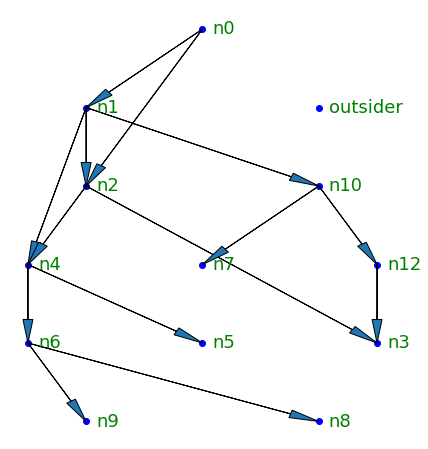

In [3]:
filename = "example.graphml"
G = nx.read_graphml(filename)
compute_and_plot(G, filename, W=3)

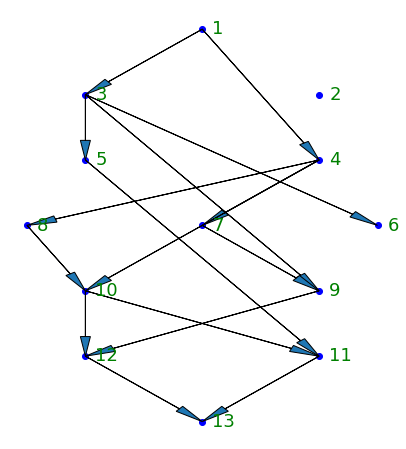

In [4]:
filename = "example2.graphml"
G = nx.read_graphml(filename)
compute_and_plot(G, filename, W=3)

## Пример работы алгоритма минимизации количества dummy-вершин (без эвристики по минимизации числа пересечений рёбер)

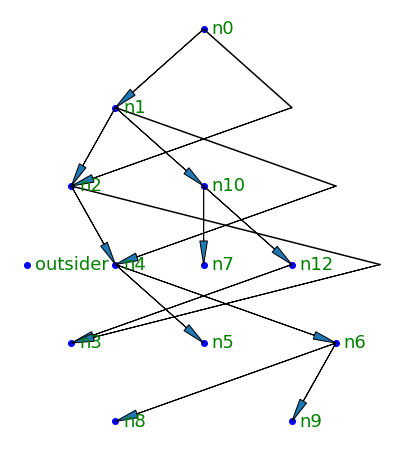

In [5]:
filename = "example.graphml"
G = nx.read_graphml(filename)
compute_and_plot(G, filename, apply_edges_minimization=False)

В моём примере алгоритм дал такое же число dummy-вершин, как и в алгоритме Грэхема-Коффмана (3). 

P.S. в алгоритме Грэхема-Коффмана я явно не рисовал dummy-вершины (это несложно, просто нерелевантно для данного алгоритма), а посчитал глазами, сколько бы их было. 

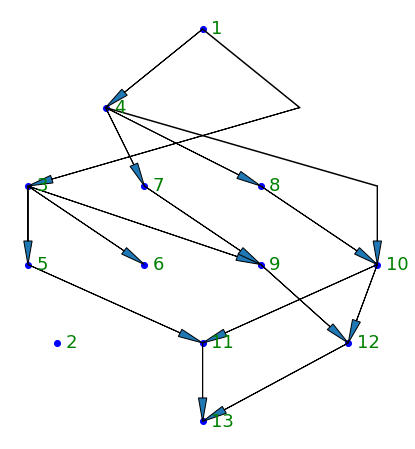

In [6]:
filename = "example2.graphml"
G = nx.read_graphml(filename)
compute_and_plot(G, filename, apply_edges_minimization=False)

В примере с лекции число dummy-вершин с переходом к новому алгоритму сократилось с 6 до 2.

## Пример работы алгоритма минимизации количества dummy-вершин (с эвристикой по минимизации числа пересечений рёбер)

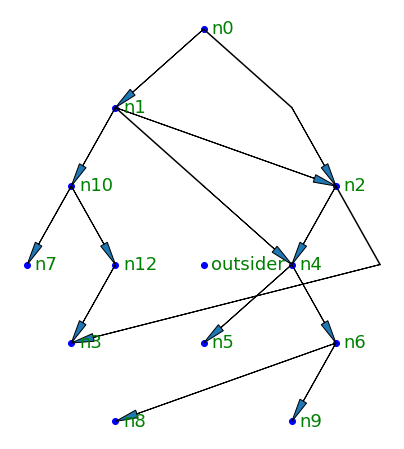

In [7]:
filename = "example.graphml"
G = nx.read_graphml(filename)
compute_and_plot(G, filename, apply_edges_minimization=True)

Отчётливо видим уменьшение числа пересечений рёбер по сравнению с отсутствующим этапом применения эвристики. Стало всего 2 пересечения, было - много.

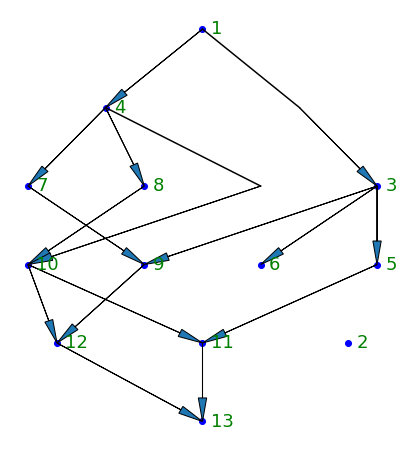

In [8]:
filename = "example2.graphml"
G = nx.read_graphml(filename)
compute_and_plot(G, filename, apply_edges_minimization=True)

В этом случае эвристика себя плохо показала ввиду её жадности. Очевидно, можно пододвинуть одну dummy-вершину налево и получить более оптимальный результат. Но алгоритм смотрит только на предыдущий слой (на вершину 4), а не на последующие. Однако всё равно наблюдаем уменьшение числа пересечений с 4 до 3.